In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!git pull

Already up to date.


In [ ]:
import os
import logging
import argparse

import numpy as np
import matplotlib
from matplotlib.ticker import StrMethodFormatter
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline

In [4]:
!pwd

/Data/repos/zoobot/notebooks


In [5]:
QUESTION = 'bars'
# QUESTION = 'smooth'

NEW_PREDICTIONS = False
# NEW_PREDICTIONS = True

### Load the (latest) model under `model_name` folder in `results_dir`

In [6]:
results_dir = '../results'
if QUESTION == 'smooth':
    shard_dir = '../data/gz2_shards/uint8_256px_smooth_n_full'
elif QUESTION == 'bars':
    shard_dir = '../data/gz2_shards/uint8_256px_bar_n_full'  # for random train/test
#     shard_dir = '../data/gz2_shards/uint8_256px_bar_n_full_nair'

tfrecord_loc = os.path.join(shard_dir, 's256_shard_0.tfrecord')  # NAIR ONLY, unlabelled shards are in the root
# tfrecord_loc = os.path.join(shard_dir, 'eval_shards/s256_shard_0.tfrecord')

#### Download previously trained model (only if new predictions needed)

In [7]:
if QUESTION == 'smooth':
    model_name = 'smooth-full'
    if NEW_PREDICTIONS:
#     128px smooth model
        !aws s3 sync s3://galaxy-zoo/results/smooth_full_96px_greyscale_9d8345e4/iteration_0/estimators/1550930190 {results_dir}/{model_name}
elif QUESTION == 'bars':
    # 128px color bars model:
    model_name = 'bars-full'
    # or 1551129992?
#     model_name = 'bars-full-nair'
    if NEW_PREDICTIONS:  # question, which to use?
        !aws s3 sync s3://galaxy-zoo/results/bars_full_128px_f084ba4_final/iteration_0/estimators/1551130721 {results_dir}/{model_name}
#         !aws s3 sync s3://galaxy-zoo/results/al_baseline_nair_bars_slightly_incomplete_8cc163c/iteration_0/estimators/1551220527 {results_dir}/{model_name}

#### Download previously-made shards (only if new predictions needed)

In [8]:
if NEW_PREDICTIONS:
    if QUESTION == 'smooth':
        if not os.path.isdir(shard_dir):
            !dvc pull -r s3 ../make_shards_smooth_full.dvc
    elif QUESTION == 'bars':
        if not os.path.isdir(shard_dir):
    #         !dvc pull -r s3 ../make_shards_bar_full.dvc
            !dvc pull -r s3 ../make_shards_bar_full_nair.dvc


### Load DECALS or GZ2 Catalog (to later construct SimulatedModel (i.e. model + labels) )

#### Option 1. DECALS Catalog

In [9]:
# simulation_timeline.ATTR_STRS 

In [10]:
# add in catalog details for more metrics
# spiral_strs = ['has-spiral-arms_yes', 'spiral-winding_prediction-encoded']
# merger_strs = ['merging_merger','merging_tidal-debris-v1' ,'merging_both-v1','merging_neither-v1','merging_major-disturbance','merging_minor-disturbance','merging_none']
# usecols = simulation_timeline.ATTR_STRS + ['subject_id', 'smooth-or-featured_smooth_fraction'] + merger_strs + spiral_strs + ['smooth-or-featured_artifact']
# spiral_strs = []
# merger_strs = []
# usecols = None

# catalog = pd.read_csv(os.path.join(shard_dir, 'labelled_catalog.csv'))

#### Option 2. GZ2 Catalog

In [11]:
gz2_catalog_loc = '../data/gz2_classifications_and_subjects.csv'
if not os.path.isfile(gz2_catalog_loc):
    !dvc pull -r s3 {gz2_catalog_loc}.dvc

+-------------------------------------------+
|                                           |
|     Update available 0.35.7 -> 0.54.0     |
|       Run pip install dvc --upgrade       |
|                                           |
+-------------------------------------------+

ERROR: failed to pull data from the cloud - '../data/gz2_classifications_and_subjects.csv.dvc' does not exist.

Having any troubles?. Hit us up at https://dvc.org/support, we are always happy to help!


In [12]:
!ls ../data/gz2

gz2_classifications_and_subjects.csv
gz2_classifications_and_subjects.csv.dvc
master_catalog.csv
master_catalog_pretend_ec2.csv
png
png.tar
png.tar.dvc
previous_classifications_renamed.csv
previous_classifications_renamed.csv.dvc
shards


In [13]:
# I messed up dvc a bit here, no worries

In [14]:
catalog = pd.read_csv('../data/gz2/gz2_classifications_and_subjects.csv', usecols=None, dtype={'subject_id': str})

In [15]:
# rename for consistency with Panoptes
catalog['smooth-or-featured_smooth_fraction'] = catalog['t01_smooth_or_features_a01_smooth_fraction']
# etc, as needed
catalog['smooth-or-featured_total-votes'] = catalog['t01_smooth_or_features_a01_smooth_count'] + catalog['t01_smooth_or_features_a02_features_or_disk_count'] + catalog['t01_smooth_or_features_a03_star_or_artifact_count']
catalog['bar_total-votes'] = catalog['t03_bar_a06_bar_count'] + catalog['t03_bar_a07_no_bar_count']

In [16]:
catalog['subject_id'] = catalog['id'].astype(str)
if QUESTION == 'smooth':
    catalog['total_votes']  = catalog['smooth-or-featured_total-votes']
    catalog['label']  = catalog['t01_smooth_or_features_a01_smooth_count']
elif QUESTION == 'bars':
    catalog['total_votes']  = catalog['bar_total-votes']
    catalog['label']  = catalog['t03_bar_a06_bar_count']

### Predict many rho for the galaxies in tfrecord_loc. Record id_strs to join into catalog later.

In [17]:
# Figures will be saved to here
save_dir = '../analysis/uncertainty/al-binomial/{}'.format(model_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
single_model_name = '{}-single'.format(model_name)
single_save_dir = '../analysis/uncertainty/al-binomial/{}'.format(single_model_name)
if not os.path.exists(single_save_dir):
    os.mkdir(single_save_dir)
assert single_save_dir != save_dir

**Stop here if you're reloading from saved predictions**

In [18]:
assert NEW_PREDICTIONS

AssertionError: 

In [ ]:
# N_SAMPLES = 200
N_SAMPLES = 30  # for Nair

# n_galaxies = 2500
n_galaxies = 6000  # for Nair

tfrecord_loc = [os.path.join(shard_dir, 's256_shard_0.tfrecord'), os.path.join(shard_dir, 's256_shard_1.tfrecord')] # NAIR ONLY, unlabelled shards are in the root

images, id_strs, samples = check_uncertainty.calculate_predictions(
    tfrecord_loc, n_galaxies, results_dir, model_name, inital_size=256, n_samples=N_SAMPLES)
assert samples.shape[1] == N_SAMPLES

In [ ]:
if QUESTION == 'smooth':
    EXPECTED_VOTES = [40 for n in range(len(samples))]
elif QUESTION == 'bars':
    EXPECTED_VOTES = [10 for n in range(len(samples))]

In [ ]:
subjects = [{'matrix': images[n], 'id_str': id_strs[n].decode('utf-8')} for n in range(len(id_strs))]
acquisitions = acquisition_utils.mutual_info_acquisition_func(samples, expected_votes=EXPECTED_VOTES)
metrics.save_iteration_state(save_dir, subjects, samples, acquisitions=acquisitions)

Repeat for single model

In [ ]:
images, id_strs, samples = check_uncertainty.calculate_predictions(
    tfrecord_loc, n_galaxies, results_dir, model_name, inital_size=256, n_samples=1) # normal model name, for path

In [ ]:
subjects = [{'matrix': images[n], 'id_str': id_strs[n].decode('utf-8')} for n in range(len(id_strs))]
acquisitions = acquisition_utils.mutual_info_acquisition_func(samples, expected_votes=EXPECTED_VOTES)
metrics.save_iteration_state(single_save_dir, subjects, samples, acquisitions=acquisitions)

In [ ]:
# model.show_mutual_info_vs_predictions(save_dir)

In [ ]:
!dvc add {save_dir}
!dvc push -r s3 {save_dir}.dvc

In [ ]:
!dvc add {single_save_dir}
!dvc push -r s3 {single_save_dir}.dvc

### Load the Saved Predictions

In [19]:
state = metrics.load_iteration_state(save_dir)
model = metrics.Model(state, name=model_name)
assert set(model.id_strs) - set(catalog['subject_id'].values) == set()

In [20]:
sim_model = simulated_metrics.SimulatedModel(model, catalog)

/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_catalog['subject_id'] = filtered_catalog['subject_id'].astype(str)


Repeat for single

In [21]:
single_state = metrics.load_iteration_state(single_save_dir)
single_model = metrics.Model(single_state, name=model_name)

In [22]:
single_sim_model = simulated_metrics.SimulatedModel(single_model, catalog)

/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_catalog['subject_id'] = filtered_catalog['subject_id'].astype(str)


Are they the same galaxies?

In [23]:
assert state.id_strs == single_state.id_strs

In [24]:
single_sim_model.labels 

array([36,  3,  6, ..., 11,  0,  0])

In [25]:
sim_model.labels

array([18, 21, 17, ...,  1,  2,  3])

(array([581., 494., 286., 208., 176., 108.,  93.,  35.,  81.,  73.,  59.,
         46.,  37.,  43.,  16.,  36.,  23.,  41.,  20.,  12.,  11.,   6.,
          2.,   6.,   3.,   1.,   2.,   0.,   0.,   1.]),
 array([ 0.        ,  1.86666667,  3.73333333,  5.6       ,  7.46666667,
         9.33333333, 11.2       , 13.06666667, 14.93333333, 16.8       ,
        18.66666667, 20.53333333, 22.4       , 24.26666667, 26.13333333,
        28.        , 29.86666667, 31.73333333, 33.6       , 35.46666667,
        37.33333333, 39.2       , 41.06666667, 42.93333333, 44.8       ,
        46.66666667, 48.53333333, 50.4       , 52.26666667, 54.13333333,
        56.        ]),
 <a list of 30 Patch objects>)

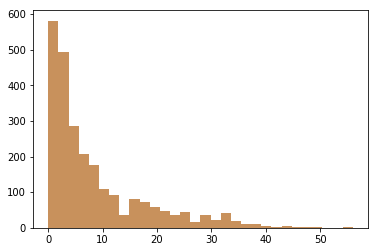

In [26]:
fig, ax = plt.subplots()
alpha = 0.6
ax.hist(single_sim_model.labels, bins=30, alpha=alpha)
ax.hist(sim_model.labels, bins=30, alpha=alpha)

They are, but in a different order - remember, catalogs are sorted by acquisition value

((array([551., 402., 321., 286., 362., 299., 139., 107.,  25.,   8.]),
  array([11. , 15.7, 20.4, 25.1, 29.8, 34.5, 39.2, 43.9, 48.6, 53.3, 58. ]),
  <a list of 10 Patch objects>),
 25.7752)

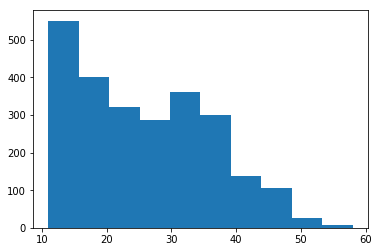

In [27]:
# to check that the right models have been loaded - should be around 40 for smooth, 0-40 for bars
plt.hist(sim_model.total_votes), sim_model.total_votes.mean()

### Visualise Posteriors

Check for systematic offset - in general, model seems slightly skewed towards low k?

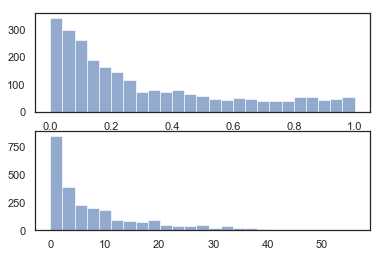

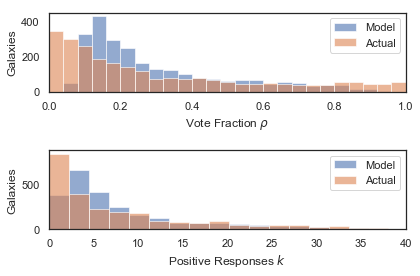

In [28]:
# sns.set_context('paper')
sns.set(font_scale=1.)
sns.set_style('white')
# matplotlib.rcParams.update({'font.size': 50}

# dummy for bins
fig, (ax0, ax1) = plt.subplots(nrows=2)
_, bins_rho, _ = ax0.hist(sim_model.labels/ sim_model.total_votes, bins=25, alpha=alpha, label='Actual')
_, bins_k, _ = ax1.hist(sim_model.labels, bins=25, alpha=alpha, label='Actual')

fig, (ax0, ax1) = plt.subplots(nrows=2)

_, bins, _ = ax0.hist(sim_model.mean_rho_prediction, bins=bins_rho, alpha=alpha, label='Model')
ax0.hist(sim_model.labels/ sim_model.total_votes, bins=bins_rho, alpha=alpha, label='Actual')
ax0.set_xlabel(r'Vote Fraction $\rho$')
ax0.set_ylabel('Galaxies')
ax0.legend()
ax0.set_xlim([0., 1.])

_, bins, _ = ax1.hist(sim_model.expected_k_prediction, bins=bins_k, alpha=alpha, label='Model')
ax1.hist(sim_model.labels, bins=bins_k, alpha=alpha, label='Actual')
ax1.set_xlabel(r'Positive Responses $k$')
ax1.set_ylabel('Galaxies')
ax1.legend()
ax1.set_xlim([0, 40])

fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.png'))
# fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.pdf'))

In [29]:
def custom_samples(samples, labels, total_votes):
    sns.set_context('paper', font_scale=1.5)
    fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples, labels, total_votes, fig, axes, alpha=0.06)
    for ax in axes:
        ax.set_xlim([0, 50])
    
    for n in range(len(labels)):
#         axes[n].set_ylabel(r'$p(v|D)$', visible=True)
        axes[n].set_ylabel(r'$p(v|w)$', visible=True)
        axes[n].yaxis.set_visible(True)
    
    axes[-1].set_xlabel('Volunteer Votes')
    fig.tight_layout()

    axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    fig.tight_layout()
    return fig

In [30]:
def custom_samples_with_galaxies(sim_model, selected_slice):
    
    samples = np.array(sim_model.model.samples)[selected_slice]
    labels = np.array(sim_model.labels)[selected_slice]
    total_votes = sim_model.total_votes[selected_slice]
    catalog = sim_model.catalog[selected_slice]
    
    
    sns.set_context('paper', font_scale=1.5)
    
    im_width = 2
    single_width = 3
    multiple_width = 3
    height = im_width
    
    fig = plt.figure(figsize=(0.8 * len(labels) * height / 1.5, 0.8 * (im_width + single_width + multiple_width) * 1.75))
    gs = gridspec.GridSpec(len(labels) * height, im_width + single_width + multiple_width)  # y, x format
    image_axes = []
    single_axes = []
    multiple_axes = []
    for galaxy_n in range(len(labels)):
        x_slice = slice(galaxy_n*height, (galaxy_n+1)*height)
        image_axes.append(plt.subplot(gs[x_slice, :im_width]))
        single_axes.append(plt.subplot(gs[x_slice, im_width:im_width+single_width]))
        multiple_axes.append(plt.subplot(gs[x_slice, im_width+single_width:]))
    

#     fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples[:, :1], labels, total_votes, fig, single_axes, alpha=0.06)
    for ax in single_axes:
        ax.set_xlim([0, 50])

    make_predictions.plot_samples(samples, labels, total_votes, fig, multiple_axes, alpha=0.06)
    for ax in multiple_axes:
        ax.set_xlim([0, 50])
        
        
    for ax_n, ax in enumerate(image_axes):
        plot_galaxy(catalog.iloc[ax_n]['png_loc'], ax)
        
    
    for n in range(len(labels)):
        multiple_axes[n].set_ylabel(r'$p(k|N, D)$', visible=True)
        multiple_axes[n].yaxis.set_visible(True)
        single_axes[n].set_ylabel(r'$p(k|N, w)$', visible=True)
        single_axes[n].yaxis.set_visible(True)
        single_axes[n].yaxis.set_major_locator(plt.NullLocator())
        multiple_axes[n].yaxis.set_major_locator(plt.NullLocator())
        if n < len(labels) - 1:
            single_axes[n].xaxis.set_major_locator(plt.NullLocator())
            multiple_axes[n].xaxis.set_major_locator(plt.NullLocator())
    
    if QUESTION == 'bars':
        question = 'Bar'
    else:
        question = 'Smooth'
    single_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
    multiple_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
    fig.tight_layout()

    single_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    
    multiple_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )

    
    fig.tight_layout()
    return fig

In [31]:
def plot_galaxy(image_loc, ax, n_examples=10, crop=0):
    im_size = 424
    im = Image.open(image_loc)
    if QUESTION == 'bars':
        crop = 120
    else:
        crop = 35
    cropped_im = im.crop((crop, crop, 424 - crop, 424 - crop))
    ax.imshow(cropped_im)
    ax.grid(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


In [32]:
# fig, axes = plt.subplots(1, 10, figsize=(20, 12))
# for ax_n, ax in enumerate(axes):
#     plot_galaxy(sim_model.catalog.iloc[ax_n]['png_loc'], ax)

In [33]:
# 1 2

In [34]:
selected = slice(80, 73, -1)  # smooth

# selected = slice(0, 7)

if QUESTION == 'bars':
    selected = slice(0, 7)

In [35]:
# np.array(sim_model.model.samples)[selected, :]
# np.array(sim_model.labels)[selected]
# sim_model.catalog['smooth-or-featured_total-votes'][selected]

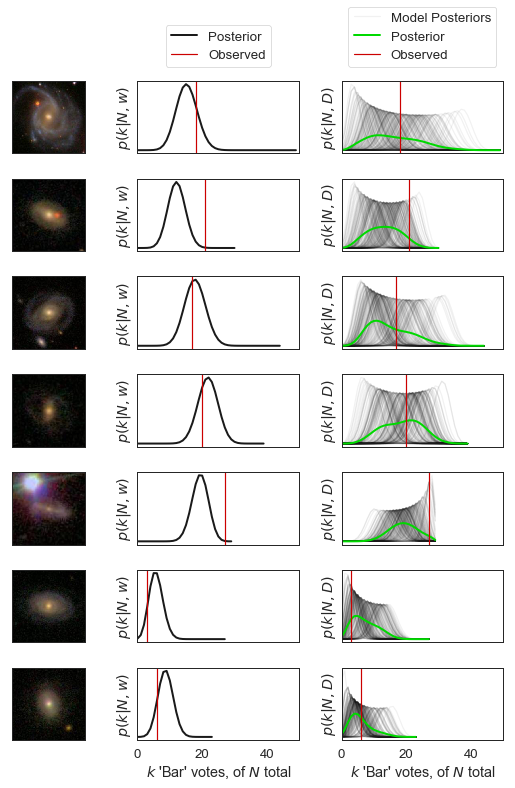

In [36]:
fig = custom_samples_with_galaxies(sim_model, selected)
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.pdf'.format(len(np.array(sim_model.labels)[selected]))))

In [37]:
# be sure to switch label in custom_samples before running this
# fig = custom_samples(np.array(single_sim_model.model.samples)[selected, :1], np.array(single_sim_model.labels)[selected], total_votes=single_sim_model.total_votes)
# fig.savefig(os.path.join(save_dir, 'single_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'single_model_{}.eps'.format(len(np.array(sim_model.labels)[selected]))))

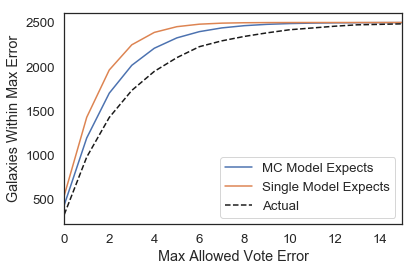

In [38]:
sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots()
ungrouped_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    sim_model.labels, 
    sim_model.bin_probs)
coverage_df = ungrouped_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()

ungrouped_single_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    single_sim_model.labels, 
    single_sim_model.bin_probs)
single_coverage_df = ungrouped_single_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()


plt.plot(coverage_df['max_state_error'], coverage_df['prediction'], label='MC Model Expects')
plt.plot(single_coverage_df['max_state_error'], single_coverage_df['prediction'], label='Single Model Expects')
plt.plot(single_coverage_df['max_state_error'], coverage_df['observed'], 'k--', label='Actual')

ax.set_xlabel('Max Allowed Vote Error')
ax.set_ylabel('Galaxies Within Max Error')
ax.legend()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))  # must expect 'x' kw arg

ax.set_xlim([0, 15])
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.png'))
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.pdf'))

In [39]:
ungrouped_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)
ungrouped_single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)

In [40]:
coverage_df['error'] = coverage_df['prediction'] - coverage_df['observed']
coverage_df['relative_error'] = coverage_df['error'] / coverage_df['observed']
coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_coverage_df.csv'), index=False)
coverage_df.head(20)

,max_state_error,prediction,observed,error,relative_error
0,0,436.622666,329.0,107.622666,0.327121
1,1,1195.800562,980.0,215.800562,0.220205
2,2,1701.689349,1427.0,274.689349,0.192494
3,3,2016.547665,1733.0,283.547665,0.163617
4,4,2209.391996,1948.0,261.391996,0.134185
5,5,2326.309405,2103.0,223.309405,0.106186
6,6,2396.891294,2227.0,169.891294,0.076287
7,7,2439.127513,2293.0,146.127513,0.063728
8,8,2464.344475,2343.0,121.344475,0.051790
9,9,2479.313308,2383.0,96.313308,0.040417


In [41]:
single_coverage_df['error'] = single_coverage_df['prediction'] - single_coverage_df['observed']
single_coverage_df['relative_error'] = single_coverage_df['error'] / single_coverage_df['observed']
single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_single_coverage_df.csv'), index=False)
single_coverage_df.head(20)

,max_state_error,prediction,observed,error,relative_error
0,0,543.625331,344.0,199.625331,0.580306
1,1,1429.417126,963.0,466.417126,0.484338
2,2,1963.608730,1363.0,600.608730,0.440652
3,3,2248.179950,1657.0,591.179950,0.356777
4,4,2388.252208,1852.0,536.252208,0.289553
5,5,2452.888617,2040.0,412.888617,0.202396
6,6,2481.139278,2150.0,331.139278,0.154018
7,7,2492.843503,2233.0,259.843503,0.116365
8,8,2497.429367,2300.0,197.429367,0.085839
9,9,2499.127190,2344.0,155.127190,0.066181


TODO - I might consider adding an MSE model as a comparison, to hopefully beat. I think this might be quite similar though. Ideally I can compare this with previous work somehow.

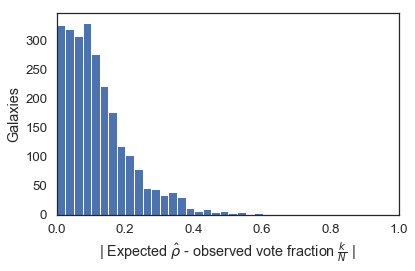

In [42]:
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots()
ax.hist(sim_model.abs_rho_error, bins=25)
# ax.axvline(sim_model.mean_abs_rho_error, color='r') 
ax.set_xlim([0, 1.])
ax.set_ylabel('Galaxies')
ax.set_xlabel(r'| Expected $\hat{\rho}$ - observed vote fraction $\frac{k}{N}$ |')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'difference_in_rho.png'))
fig.savefig(os.path.join(save_dir, 'difference_in_rho.pdf'))

In [43]:
sim_model.abs_rho_error.mean(), single_sim_model.abs_rho_error.mean()

(0.11947315856439396, 0.12908678803398907)

In [44]:
np.sqrt(sim_model.mean_abs_rho_error), np.sqrt(single_sim_model.mean_abs_rho_error)  

(0.34564889492719914, 0.35928649854119077)

In [45]:
np.sqrt(sim_model.mean_square_rho_error), np.sqrt(single_sim_model.mean_square_rho_error) # this is the rmse

(0.15355329240266494, 0.1683954660670965)

In [46]:
# alpha = 0.3
# n_bins = 25

# # dummy for bins
# fig, ax = plt.subplots()
# _, bins, _  = ax.hist(sim_model.labels / sim_model.total_votes, bins=n_bins, alpha=alpha, label=r'Observed $\rho$')
# ax.hist(sim_model.mean_rho_prediction, bins=n_bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')

# fig, ax = plt.subplots()
# sns.set(font_scale=1.)
# sns.set_style('white')

# ax.hist(sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')
# ax.hist(sim_model.labels / sim_model.total_votes, bins=bins, alpha=alpha, label=r'Observed $\rho$')
# ax.legend()
# ax.set_xlim([0., 1.])
# ax.set_ylabel('Galaxies')
# ax.set_xlabel(r'Typical vote fraction $\rho$')
# fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'typical_vote_fraction_distribution.png'))

# This is a repeat of the above histograms

In [47]:
np.sum(sim_model.mean_rho_prediction > 0.5), np.sum(single_sim_model.mean_rho_prediction > 0.5), np.sum((sim_model.labels / sim_model.total_votes) > 0.5)

(452, 466, 561)

In [48]:
(sim_model.labels / sim_model.total_votes).min(), (sim_model.labels / sim_model.total_votes).max()

(0.0, 1.0)

In [49]:
sim_model.mean_rho_prediction.min(), sim_model.mean_rho_prediction.max()

(0.050554523887112734, 0.9765037423372269)

In [50]:
single_sim_model.mean_rho_prediction.min(), single_sim_model.mean_rho_prediction.max()

(0.01879390887916088, 0.9978042244911194)

In [51]:
sim_model.total_votes

array([49, 30, 44, ..., 13, 38, 46])

## Save DataFrame of predictions + catalog (GZ2) for use elsewhere

In [93]:
response_df = pd.DataFrame(data={
    'total_votes': sim_model.total_votes, 
    'k': sim_model.labels, 
    'vote_fraction': (sim_model.labels / sim_model.total_votes), 
    'rho_prediction': sim_model.mean_rho_prediction
#     'png_loc': sim_model.catalog.png_loc
})
safe_catalog_cols = list(set(sim_model.catalog.columns.values) - set(['total_votes', 'ra_subject', 'dec_subject']))
df = pd.concat([response_df, sim_model.catalog[safe_catalog_cols]], axis=1)
df['smooth'] = df['vote_fraction'] > 0.5
df['confidence_proxy'] = np.abs(0.5 - df['rho_prediction'])
df = df.sort_values('confidence_proxy', ascending=False)

In [56]:
df.head()

,total_votes,k,vote_fraction,rho_prediction,name,t08_odd_feature_a21_disturbed_fraction,t02_edgeon_a04_yes_debiased,t08_odd_feature_a24_merger_weighted_fraction,t11_arms_number_a32_2_count,t01_smooth_or_features_a02_features_or_disk_debiased,...,t07_rounded_a18_cigar_shaped_weighted_fraction,t03_bar_a06_bar_debiased,t08_odd_feature_a23_other_weight,t03_bar_a07_no_bar_fraction,label,t08_odd_feature_a24_merger_count,dec,t04_spiral_a09_no_spiral_weight,smooth,confidence_proxy
620,42,42,1.000000,0.976504,587725551193227296,0.00,0.067000,0.000,35,0.955,...,0.000,1.000000,1.0,0.000,42,0,41.386375,0.0,True,0.476504
221,33,33,1.000000,0.953262,587732771044589668,0.25,0.002248,0.006,33,0.999,...,0.943,1.000000,2.0,0.000,33,1,8.521611,0.0,True,0.453262
612,26,26,1.000000,0.951207,587738617566658645,0.60,0.001567,0.000,10,1.000,...,0.000,1.000000,0.0,0.000,26,0,38.065895,3.0,True,0.451207
355,36,36,1.000000,0.950606,587733604804460651,0.00,0.159000,0.000,12,0.842,...,0.000,1.000000,4.0,0.000,36,0,39.518539,22.0,True,0.450606
2451,29,1,0.034483,0.050555,587742061623836806,0.00,0.000000,0.000,3,0.795,...,0.000,0.043602,1.0,0.966,1,0,19.160263,2.0,False,0.449445


In [97]:
df.to_parquet('/data/repos/zoobot/notebooks/{}_test_predictions_and_gz2_catalog.parquet'.format(QUESTION))

### Replicate (ish) Sanchez 2017 ROC Curves

In [52]:
confusion_matrix((sim_model.labels / sim_model.total_votes) > 0.5, sim_model.mean_rho_prediction > 0.5)

array([[1857,   82],
       [ 191,  370]])

In [53]:
 1 - ((66 + 99) / (490 + 1845 + 66 + 99))

0.9339999999999999

In [54]:
 1 - ((189 + 81) / (1858 + 189 + 81 + 372))

0.892

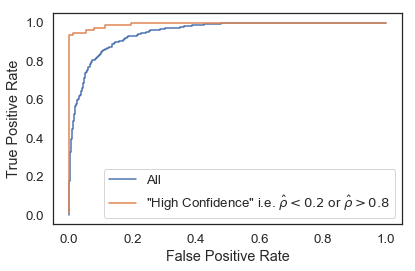

In [57]:
fig, ax = plt.subplots()
sns.set(font_scale=1.2)
sns.set_style('white')

fpr, tpr, _ = roc_curve(df['smooth'], df['rho_prediction'])
ax.plot(fpr, tpr, label='All')
df_low_entropy = df[df['confidence_proxy'] > 0.3]
fpr, tpr, _ = roc_curve(df_low_entropy['smooth'], df_low_entropy['rho_prediction'])
ax.plot(fpr, tpr, label=r'"High Confidence" i.e. $\hat{\rho} < 0.2$ or $\hat{\rho} > 0.8$')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'roc_curve.png'))
fig.savefig(os.path.join(save_dir, 'roc_curve.pdf'))

In [58]:
len(df), len(df_low_entropy)

(2500, 1174)

### Replicate(ish) Khan 2018 Confusion Matrices

> After selecting the OBJIDs from Table 2 based on the probability thresholds of 0.985 and 0.926 for spirals and ellipticals respectively,

In [59]:
df.sample(1)

,total_votes,k,vote_fraction,rho_prediction,name,t08_odd_feature_a21_disturbed_fraction,t02_edgeon_a04_yes_debiased,t08_odd_feature_a24_merger_weighted_fraction,t11_arms_number_a32_2_count,t01_smooth_or_features_a02_features_or_disk_debiased,...,t07_rounded_a18_cigar_shaped_weighted_fraction,t03_bar_a06_bar_debiased,t08_odd_feature_a23_other_weight,t03_bar_a07_no_bar_fraction,label,t08_odd_feature_a24_merger_count,dec,t04_spiral_a09_no_spiral_weight,smooth,confidence_proxy
2350,14,0,0.0,0.093874,587739814779617674,0.0,0.01579,0.0,1,0.81,...,0.0,0.0,0.0,1.0,0,0,20.06599,2.0,False,0.406126


In [60]:
cdf_array = binom.cdf((df['total_votes'] / 2.).astype(int), df['total_votes'], df['rho_prediction'])

In [61]:
(df['total_votes'] / 2.).astype(int).sample(10)

306     25
1648     6
341     15
417      5
680     10
2482    13
1988     7
1638     9
1798     8
274     22
Name: total_votes, dtype: int64

In [62]:
df['total_votes'].sample(10)

342     37
1150    20
805     20
496     11
2452    11
2073    28
2410    22
1278    40
1525    14
223     21
Name: total_votes, dtype: int64

In [63]:
df['rho_prediction'].sample(10)

1909    0.163584
854     0.666705
339     0.196347
473     0.661919
1400    0.207294
1453    0.342491
192     0.623045
1437    0.276616
2299    0.056227
1651    0.113046
Name: rho_prediction, dtype: float64

(array([ 209.,   27.,   22.,   19.,   14.,   21.,   19.,   12.,   16.,
           7.,   25.,    9.,   16.,   13.,    7.,    7.,   15.,   19.,
          15.,   22.,   17.,   11.,   21.,   22.,   24.,   28.,   45.,
          57.,   93., 1668.]),
 array([2.06626060e-23, 3.33333333e-02, 6.66666667e-02, 1.00000000e-01,
        1.33333333e-01, 1.66666667e-01, 2.00000000e-01, 2.33333333e-01,
        2.66666667e-01, 3.00000000e-01, 3.33333333e-01, 3.66666667e-01,
        4.00000000e-01, 4.33333333e-01, 4.66666667e-01, 5.00000000e-01,
        5.33333333e-01, 5.66666667e-01, 6.00000000e-01, 6.33333333e-01,
        6.66666667e-01, 7.00000000e-01, 7.33333333e-01, 7.66666667e-01,
        8.00000000e-01, 8.33333333e-01, 8.66666667e-01, 9.00000000e-01,
        9.33333333e-01, 9.66666667e-01, 1.00000000e+00]),
 <a list of 30 Patch objects>)

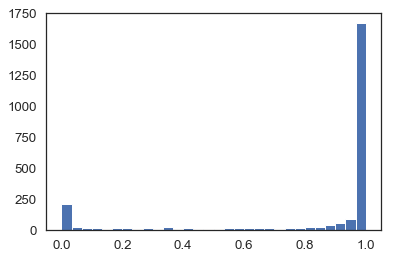

In [64]:
plt.hist(cdf_array, bins=30)

In [65]:
binom.cdf(20, 40, 0.88)

4.701387986481546e-09

In [66]:
sum(1 - cdf_array > 0.985)

174

In [67]:
sum(cdf_array > 0.926)

1777

In [68]:
high_prob_df = df[(cdf_array < (1 - 0.985)) | (cdf_array > 0.926)]

In [69]:
len(high_prob_df)

1951

In [70]:
if QUESTION == 'smooth':
    spiral_pc_to_keep = 516 / 6677
    n_spirals = int(len(df) * spiral_pc_to_keep)
    elliptical_pc_to_keep = 550 / 5904
    n_ellipticals = int(len(df) * elliptical_pc_to_keep)
    print(spiral_pc_to_keep, n_spirals, elliptical_pc_to_keep, n_ellipticals)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:n_spirals],
        df.sort_values('rho_prediction', ascending=False)[:n_ellipticals]
    ])
if QUESTION == 'bars':
    n_to_keep = int(len(df) * 0.08)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:int(n_to_keep/2)],
        df.sort_values('rho_prediction', ascending=False)[:int(n_to_keep/2)]
    ])



In [71]:
high_prob_df.sample(20)

,total_votes,k,vote_fraction,rho_prediction,name,t08_odd_feature_a21_disturbed_fraction,t02_edgeon_a04_yes_debiased,t08_odd_feature_a24_merger_weighted_fraction,t11_arms_number_a32_2_count,t01_smooth_or_features_a02_features_or_disk_debiased,...,t07_rounded_a18_cigar_shaped_weighted_fraction,t03_bar_a06_bar_debiased,t08_odd_feature_a23_other_weight,t03_bar_a07_no_bar_fraction,label,t08_odd_feature_a24_merger_count,dec,t04_spiral_a09_no_spiral_weight,smooth,confidence_proxy
198,36,36,1.000000,0.889150,587726033318117592,0.000,0.023531,0.000,24,0.947,...,0.000,1.000000,0.000,0.000,36,0,2.972616,11.0,True,0.389150
2149,12,1,0.083333,0.085884,587739706872496154,0.000,0.009173,0.077,0,0.939,...,0.000,0.202044,2.000,0.917,1,1,26.274027,9.0,False,0.414116
313,32,32,1.000000,0.804124,587739132960506081,0.333,0.000000,0.000,11,1.000,...,0.000,1.000000,1.000,0.000,32,0,30.619621,14.0,True,0.304124
2498,38,2,0.052632,0.062220,587736543097651427,0.000,0.024246,0.000,7,0.954,...,0.000,0.067683,3.000,0.947,2,0,7.864749,0.0,False,0.437780
437,28,27,0.964286,0.796000,587725552269328753,0.000,0.000215,0.000,6,0.971,...,0.000,0.998430,1.112,0.036,27,0,46.455547,9.0,True,0.296000
95,29,15,0.517241,0.781014,587739382595321870,0.000,0.000000,0.000,13,0.879,...,0.000,0.517000,1.000,0.483,15,0,33.307789,12.0,True,0.281014
268,36,35,0.972222,0.910586,587725471211651227,0.000,0.004055,0.000,7,0.999,...,0.000,0.982758,0.000,0.028,35,0,59.791256,2.0,True,0.410586
1596,12,0,0.000000,0.080637,587725470665998613,0.000,0.011947,0.000,2,0.879,...,0.000,0.000000,0.958,1.000,0,0,45.154835,7.0,False,0.419363
2476,34,3,0.088235,0.081627,587732482202861656,0.000,0.006133,0.000,23,1.000,...,0.000,0.291855,2.000,0.912,3,0,44.112667,2.0,False,0.418373
2491,19,1,0.052632,0.075635,588017979986673855,0.000,0.000100,0.000,3,0.994,...,0.000,0.119497,4.000,0.947,1,0,27.579098,0.0,False,0.424365


In [72]:
confusion_matrix(high_prob_df['vote_fraction'] >= 0.5, high_prob_df['rho_prediction'] >= 0.5)

array([[100,   0],
       [  0, 100]])

In [73]:
error = high_prob_df[~(high_prob_df['vote_fraction'] > 0.5) & (high_prob_df['rho_prediction'] > 0.5)]

In [74]:
error

,total_votes,k,vote_fraction,rho_prediction,name,t08_odd_feature_a21_disturbed_fraction,t02_edgeon_a04_yes_debiased,t08_odd_feature_a24_merger_weighted_fraction,t11_arms_number_a32_2_count,t01_smooth_or_features_a02_features_or_disk_debiased,...,t07_rounded_a18_cigar_shaped_weighted_fraction,t03_bar_a06_bar_debiased,t08_odd_feature_a23_other_weight,t03_bar_a07_no_bar_fraction,label,t08_odd_feature_a24_merger_count,dec,t04_spiral_a09_no_spiral_weight,smooth,confidence_proxy
388,30,15,0.5,0.801508,587733603182051449,0.0,0.0,0.0,7,0.976,...,0.0,0.837742,0.0,0.5,15,0,55.481575,14.0,False,0.301508


In [75]:
error['vote_fraction'] > 0.5, error['rho_prediction'] > 0.5

(388    False
 Name: vote_fraction, dtype: bool, 388    True
 Name: rho_prediction, dtype: bool)

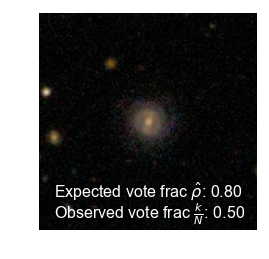

In [76]:
img = Image.open(error.iloc[0]['png_loc'])
plt.imshow(img)
fontdict = {'size': 16, 'color': 'white'}
plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.80', fontdict=fontdict)
plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.50', fontdict=fontdict)
plt.axis('off')
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.png'))
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.eps'))

In [77]:
# img = Image.open(error.iloc[1]['png_loc'])
# plt.imshow(img)
# fontdict = {'size': 16, 'color': 'white'}
# plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.13', fontdict=fontdict)
# plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.54', fontdict=fontdict)
# plt.axis('off')
# plt.savefig(os.path.join(save_dir, 'high_prob_error_1.png'))
# plt.savefig(os.path.join(save_dir, 'high_prob_error_1.eps'))

In [78]:
confusion_matrix(df['vote_fraction'][:int(len(df) / 2)] > 0.5, df['rho_prediction'][:int(len(df) / 2)] > 0.5)

array([[1160,    1],
       [   7,   82]])

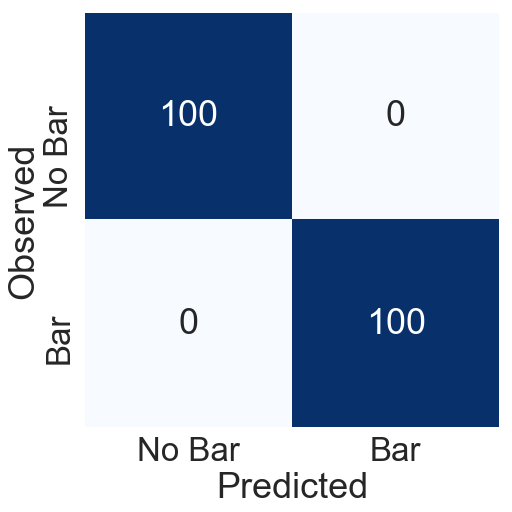

In [79]:
if QUESTION == 'smooth':
    labels = ['Smooth', 'Featured']
    
#     cm = np.array([[ 232,    2], [   0, 191]])
#     name = 'confusion_matrix_high_confidence'
    
    cm = np.array([[ 490,   66],
       [  99, 1845]])
    name = 'confusion_matrix'
    
if QUESTION == 'bars':
    labels = ['No Bar', 'Bar']
    cm = np.array([[100,    0], [   0,   100]])
    name = 'confusion_matrix_high_confidence'
    
#     cm = np.array([[1858,    81], [   189,   372]])
#     name = 'confusion_matrix'

sns.set(font_scale=3.)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False, square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, '{}.png'.format(name)))
fig.savefig(os.path.join(save_dir, '{}.pdf'.format(name)))

In [80]:
1 - (8 / (1159 + 83 + 8))

0.9936

In [81]:
# sim_model.export_performance_metrics(save_dir)

In [82]:
# Draw a galaxy, infer a range of p, redraw, and measure accuracy - work in progress

In [83]:
# prange = np.linspace(0, 1., num=200)
# num_galaxies = 25000
# errors = 0
# for n in range(num_galaxies):
#     gal_n = np.random.choice(range(len(sim_model.labels)))
#     rho_obs = sim_model.labels[gal_n] # same distribution as rho that we see, unbiased
#     k_obs = int(rho_obs * 40)
#     k_plausible = binom.rvs(n=sim_model.total_votes[gal_n], p=rho_obs)
#     if (k_obs > 20 and k_plausible < 20) or (k_obs < 20 and k_plausible > 20):
#         errors += 1
# print(errors / num_galaxies)

### Plot other standard acquisition visualisations

In [84]:
new_acquisition_viz = False
if new_acquisition_viz:
    image_locs = sim_model.catalog['png_loc']
    images = np.stack([np.array(Image.open(loc)) for loc in image_locs])
    assert images.shape == (2500, 424, 424, 3)
    acquisition_utils.save_acquisition_examples(images, sim_model.mutual_info, 'mutual_info', save_dir)

In [85]:
# fig, row = plt.subplots(ncols=3, figsize=(12, 4))

In [86]:
# row = sim_model.acquisition_vs_volunteer_votes(row)

### Visualise Selection of Catalog Features w.r.t. Acquisition Function

In [87]:
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
gs = gridspec.GridSpec(6, 5, figure=fig)

<Figure size 1440x864 with 0 Axes>

#### Smooth Votes

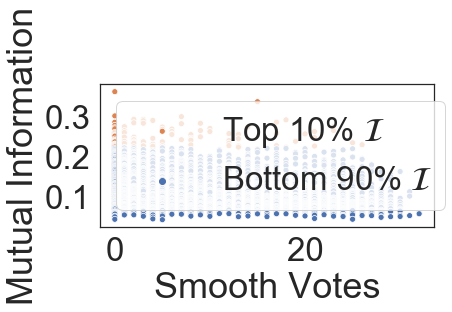

In [88]:
ax0 = plt.subplot(gs[:4, :])
sns.scatterplot(
    np.array(sim_model.catalog['smooth-or-featured_smooth_fraction'] * 40).astype(int),
    sim_model.model.acquisitions, hue=np.array(sim_model.model.acquisitions) > np.array(sim_model.model.acquisitions[103]),
    ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Smooth Votes')
ax0.legend([r'Top 10% $\mathcal{I}$', r'Bottom 90% $\mathcal{I}$'])

Text(0.5,0,'Smooth Votes')

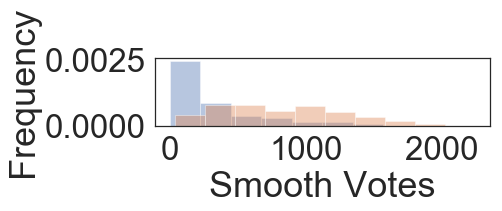

In [89]:
ax1 = plt.subplot(gs[4:, :])
ax1.hist(np.array(sim_model.labels * 40).astype(int), density=True, alpha=0.4)
ax1.hist(np.array(sim_model.labels * 40).astype(int)[:200], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')

In [90]:
plt.savefig(os.path.join(save_dir, 'temp.png'))

<Figure size 432x288 with 0 Axes>

#### Redshift

KeyError: 'redshift'

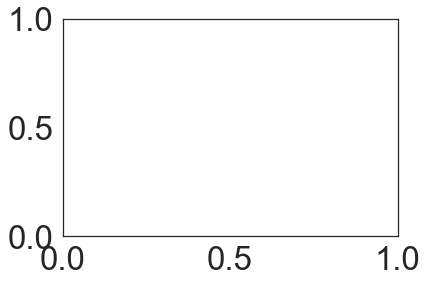

In [91]:
fig, ax = plt.subplots()
sns.jointplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], kind='kde')
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.jointplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], kind='kde', ax=ax0)
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.jointplot(sim_model.catalog['redshift'], sim_model.model.acquisitions, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Redshift')

In [ ]:
ax1 = plt.subplot(gs[4:, :])

ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
# ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')
# TODO sort by mutual information

### Below here is only relevant for DECALS, with extra questions. TODO update with GZ2 merger options?

In [ ]:
assert False

In [ ]:
merger_strs

In [ ]:
merger_label = 'merging_major-disturbance'

In [ ]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(sim_model.catalog[merger_label], sim_model.model.mutual_info, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel(merger_label)

In [ ]:
_ = plt.hist(sim_model.catalog[merger_label], bins=40)

In [ ]:
featured_no_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] == 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]
featured_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] > 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]

In [ ]:
featured_no_merger.mean()

In [ ]:
featured_merger.mean()

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.hist(featured_no_merger, alpha=0.3, density=True)

In [ ]:
ax.hist(featured_merger, alpha=0.3, density=True)

In [ ]:
fig

In [ ]:
ax = sns.scatterplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info, 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[103])
ax.set_xlim([0, 14.5])

In [ ]:
sns.regplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig

In [ ]:
has-spiral-arms_yes
spiral-winding_prediction-encoded

In [ ]:
sns.scatterplot(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    sim_model.model.mutual_info[sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[100])

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [ ]:
for merger_label in merger_strs:
    print('\n' + merger_label)
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] > 1].mean())
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] == 1].mean())

In [ ]:
data = [
    {'Volunteer Response': 'Merging', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_both-v1'] > 1].mean()},
    {'Volunteer Response': 'Major Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_major-disturbance'] > 1].mean()},
    {'Volunteer Response': 'Minor Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_minor-disturbance'] > 1].mean()},
    {'Volunteer Response': 'No Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_none'] > 20].mean()}
    ]

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots()
ax = sns.barplot(data=df, y='Volunteer Response', x='Mean Mutual Information', ax=ax)
ax.set_xlim([0.2, 0.36])
fig.tight_layout()

In [ ]:
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) > 0].mean())
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) == 0].mean())

In [ ]:
plt.hist(sim_model.catalog['merging_tidal-debris-v1'], bins=40)